# REFMAP laboratory listening test 1 analysis: Exploratory data analysis — all data

## Setup

In [6]:
# import statements
import sys
import os
import numpy as np
import pandas as pd
from PyQt5.QtWidgets import QFileDialog, QApplication
import librosa
import dsp.filterFuncs
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pingouin as pg


In [9]:
# set plot parameters
sns.set_style('white')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'

SMALL_SIZE = 9
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE,
       labelsize=MEDIUM_SIZE)    # fontsize of the axes title and x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mycolours = [(0, 102, 255), (0, 204, 153), (255, 0, 102), (74, 111, 152),
             (251, 164, 49), (204, 153, 255), (90, 192, 255), (80, 245, 233),
             (255, 90, 192), (164, 201, 242), (255, 254, 139), (255, 243, 255)]
mycolours = [tuple(shade/255 for shade in colour) for colour in mycolours]


# enable copy-on-write mode for Pandas (will be default from Pandas 3.0)
pd.options.mode.copy_on_write = True

# check/open QApplication instance
if not QApplication.instance():
    app = QApplication(sys.argv)
else:
    app = QApplication.instance() 

Set the saveplots toggle to True if plot saving is desired:

In [10]:
saveplots = False

if saveplots:
    # select figure output save path
    outFigPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save plots")

## Import data and organise

In [11]:
# import data
fileExts = "*.csv"

# Part A
dataByStimAFilePath = list(QFileDialog.getOpenFileName(filter=fileExts,
                                                       caption=r"Open refmap_listest1_testdataA_ByStim.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataByStimTestA = pd.read_csv(dataByStimAFilePath, index_col=0)

partADataFilePath = list(QFileDialog.getOpenFileName(filter=fileExts,
                                                     caption=r"Open refmap_listest1_testdataA_BySubj.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
partADataBySubj = pd.read_csv(partADataFilePath, index_col=False)


# Part B
dataByStimBFilePath = list(QFileDialog.getOpenFileName(filter=fileExts,
                                                       caption=r"Open refmap_listest1_testdataB_ByStim.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataByStimTestB = pd.read_csv(dataByStimBFilePath, index_col=0)

partBDataFilePath = list(QFileDialog.getOpenFileName(filter=fileExts,
                                                     caption=r"Open refmap_listest1_testdataB_BySubj.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
partBDataBySubj = pd.read_csv(partBDataFilePath, index_col=False)


FileNotFoundError: [Errno 2] No such file or directory: ''

In [5]:
# categorise columns

for dataset in [dataByStimTestA, partADataBySubj]:
    dataset['AmbientEnv'] = pd.Categorical(dataset['AmbientEnv'], ["Park", "Street"], ordered=True)
    dataset['SNRlevel'] = pd.Categorical(dataset['SNRlevel'], ["No UAS", "-16", "-10", "-4", "2", "8"], ordered=True)
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'], ["No UAS", "42", "48", "54", "60"], ordered=True)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["No UAS", "Flyby", "Landing", "Takeoff"], ordered=True)
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["No UAS", "H520", "M300", "T150"], ordered=True)

for dataset in [dataByStimTestB, partBDataBySubj]:
    dataset['AmbientEnv'] = pd.Categorical(dataset['AmbientEnv'], ["Park", "Street"], ordered=True)
    dataset['SNRlevel'] = pd.Categorical(dataset['SNRlevel'], ["No UAS", "2", "8"], ordered=True)
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'], ["No UAS", "54", "60"], ordered=True)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["No UAS", "Flyby"], ordered=True)
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["No UAS", "H520", "T150"], ordered=True)


## Exploratory data analysis and checking

In this section, exploratory plots are used to examine the data for information and possible trends.

The relationship between the median and mean annoyance responses are examined, to explore how the use of one or other as a measure for central tendency within the data might affect modelling outcomes and inferences.

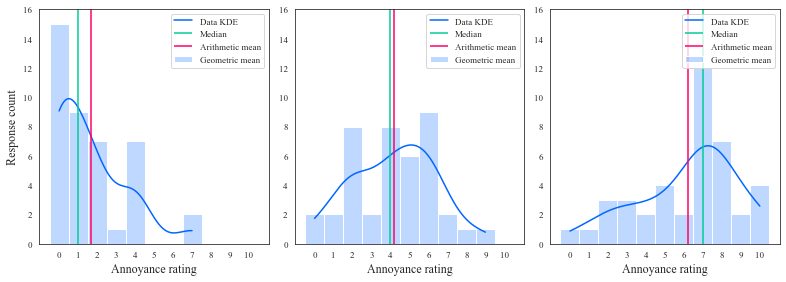

In [14]:
# histogram plot of extreme annoyance distributions for Part A

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 4))

data = [partADataBySubj.loc[partADataBySubj['Recording']
                            == "A2_CALBIN_Pa.wav", 'Annoyance'],
        partADataBySubj.loc[partADataBySubj['Recording']
                            == "A2_H520_F_2_R_CALBIN_Pa.wav", 'Annoyance'],
        partADataBySubj.loc[partADataBySubj['Recording']
                            == "A2_H520_L_1_CALBIN_Pa.wav", 'Annoyance']]

for ii, ax in enumerate(axs):
    sns.histplot(data=data[ii], color=mycolours[0], alpha=0.25,
                 bins=np.arange(-0.5, 11.5, 1), ax=ax, kde=True)
    ax.vlines(x=np.median(data[ii]), ymin=0, ymax=20,
              colors=mycolours[1], linewidth=1.5)
    ax.vlines(x=np.mean(data[ii]), ymin=0, ymax=20,
              colors=mycolours[2], linewidth=1.5)
    ax.set(xticks=range(0, 11, 1), ylim=[0, 16], xlabel="Annoyance rating")
    ax.legend(labels=["Data KDE", "Median", "Arithmetic mean", "Data"])
    if ii == 0:
        ax.set(ylabel="Response count")
    else:
        ax.set(ylabel=None)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "MedianVsMeanAnnoyHistH520.svg"),
                format='svg')
plt.show()


The histogram plot gives one example from Part A of how assymetrical response distributions could result in the tendency for the mean values to 'lean inwards' from the extreme ends of the bounded response scales. 

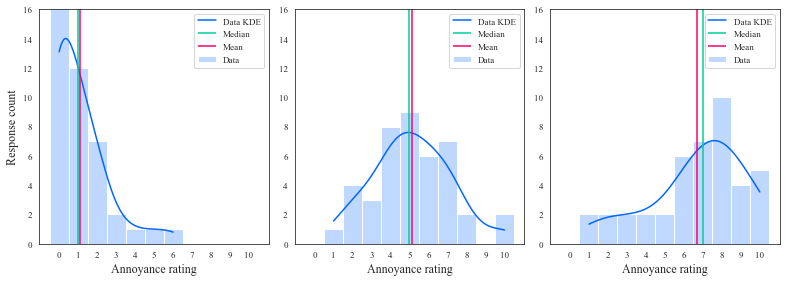

In [23]:
# histogram plot of extreme annoyance distributions for Part B

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 4))

data = [partBDataBySubj.loc[partBDataBySubj['Recording']
                            == "B2_CALBIN_Pa.wav", 'Annoyance'],
        partBDataBySubj.loc[partBDataBySubj['Recording']
                            == "B2_T150_F_2_L_3_CALBIN_Pa.wav", 'Annoyance'],
        partBDataBySubj.loc[partBDataBySubj['Recording']
                            == "B2_T150_F_1_R_9_CALBIN_Pa.wav", 'Annoyance']]

for ii, ax in enumerate(axs):
    sns.histplot(data=data[ii], color=mycolours[0], alpha=0.25,
                 bins=np.arange(-0.5, 11.5, 1), ax=ax, kde=True)
    ax.vlines(x=np.median(data[ii]), ymin=0, ymax=20,
              colors=mycolours[1], linewidth=1.5)
    ax.vlines(x=np.mean(data[ii]), ymin=0, ymax=20,
              colors=mycolours[2], linewidth=1.5)
    ax.set(xticks=range(0, 11, 1), ylim=[0, 16], xlabel="Annoyance rating")
    ax.legend(labels=["Data KDE", "Median", "Mean", "Data"])
    if ii == 0:
        ax.set(ylabel="Response count")
    else:
        ax.set(ylabel=None)
if saveplots:
    plt.savefig(os.path.join(outFigPath, "MedianVsMeanAnnoyHistT150.svg"),
                format='svg')
plt.show()


This histogram plot shows a less extreme example from Part B of how assymetrical response distributions could result in the tendency for the mean values to 'lean inwards' from the extreme ends of the bounded response scales. In this case, the mean and the median are in closer agreement, although the example towards the upper extreme still shows the mean being pulled downwards by atypical responses at the low end.

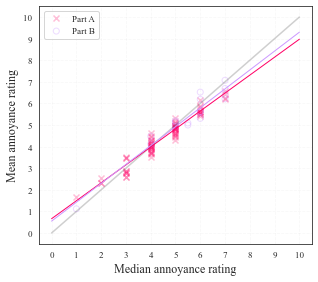

In [7]:
# median vs mean annoyance for both Parts A and B
fig, ax = plt.subplots(figsize=(4.5, 4))

ax.plot([0, 10], [0, 10], linestyle='-', color=[0.25, 0.25, 0.25], alpha=0.25)
ax.scatter(x=dataByStimTestA['AnnoyMedian'], y=dataByStimTestA['AnnoyMean'],
           color=mycolours[2], alpha=0.25, label="Part A", marker='x')
ax.set(xticks=range(0, 11), xlabel="Median annoyance rating",
       yticks=range(0, 11), ylabel="Mean annoyance rating")

# linear regression line
b, a = np.polyfit(dataByStimTestA['AnnoyMedian'], dataByStimTestA['AnnoyMean'],
                  deg=1)
xseq = np.linspace(0, 10, num=11)
ax.plot(xseq, a + b * xseq, color=mycolours[2], linewidth=1)

ax.scatter(x=dataByStimTestB['AnnoyMedian'], y=dataByStimTestB['AnnoyMean'],
           color=mycolours[5], alpha=0.35, label="Part B", marker='o',
           facecolor='none')
ax.set(xticks=range(0, 11), xlabel="Median annoyance rating",
       yticks=range(0, 11), ylabel="Mean annoyance rating")

# linear regression line
b, a = np.polyfit(dataByStimTestB['AnnoyMedian'], dataByStimTestB['AnnoyMean'],
                  deg=1)
xseq = np.linspace(0, 10, num=11)
ax.plot(xseq, a + b * xseq, color=mycolours[5], linewidth=1)


ax.grid(alpha=0.15, linestyle='--')
ax.legend()

if saveplots:
    plt.savefig(os.path.join(outFigPath, "MedianVsMeanAnnoyScatReg.svg"),
                format='svg')
plt.show()


This scatter plot and linear regression demonstrates how the use of mean annoyance ratings results in a compressed response range compared with the use of the median values, and that the effect is marginally greater with Part A than with Part B.